## Final Project Submission

Please fill out:
* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


In [1]:
# Importing useful libraries
import pandas as pd
import sqlite3
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
# Reading training dataset that was retrieved from kaggle
trainset = pd.read_csv('Tan_Train.csv', low_memory=False)
testset = pd.read_csv('Tan_Test.csv', low_memory=False)
labels = pd.read_csv('Tan_Labels.csv')
trainset.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
# A lot of info is chopped off, so I'm making a
# function that doesn't cut off any columns
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [4]:
display_all(trainset.head())

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
print(trainset.shape)
print(labels.shape)

(59400, 40)
(59400, 2)


The status labels can be added to the training set using the id code

In [6]:
df = trainset.merge(labels, on="id")

In [7]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
strings = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
          'lga', 'ward', 'recorded_by', 'scheme_management',
          'scheme_name', 'extraction_type', 'extraction_type_group',
          'extraction_type_class', 'management', 'management_group', 'payment',
          'payment_type','water_quality', 'quality_group', 'source', 'source_type',
          'source_class', 'waterpoint_type']

In [9]:
# make all string columns lower case to compare and group them
for column in strings:
    df[column] = df[column].str.lower()
    testset[column] = testset[column].str.lower()

In [10]:
# isolate the year from date recorded
df['date_recorded']=pd.to_datetime(df.date_recorded)
df['year']=df.date_recorded.dt.year
df['month']=df.date_recorded.dt.month
df['day']=df.date_recorded.dt.day

testset['date_recorded']=pd.to_datetime(testset.date_recorded)
testset['year']=testset.date_recorded.dt.year
testset['month']=testset.date_recorded.dt.month
testset['day']=testset.date_recorded.dt.day

df['year'].value_counts(dropna=False)

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: year, dtype: int64

There are very few dates before 2011, so I'm going to replace the date with 2011, the year with the most data.

In [11]:
df2 = df.copy() # Leaving a copy of the original dataframe
df2.drop(['date_recorded'], axis=1, inplace=True)
df2['year'] = df2['year'].where(df2['year'] > 2010, 2011)

testset2 = testset.copy()
testset2.drop(['date_recorded'], axis=1, inplace=True)
testset2['year'] = testset2['year'].where(testset2['year'] > 2010, 2011)

In [12]:
#function fills NaN values with a random number in interval
def clean(dataframe, column, l, h):
        array = np.random.uniform(low=l, high=h, size=dataframe.shape[0])
        dataframe['{}'.format(column)]=dataframe['{}'.format(column)].mask(pd.isnull, array)

In [13]:
# Function to encode column into integer values
def encode(dataframes, column):
    for x in dataframes:
        le = LabelEncoder().fit(x['{}'.format(column)])
        x['{}'.format(column)] = le.transform(x['{}'.format(column)])

In [14]:
# Function to replace numbers below a certain value with NaN
def replacemore(dataframes, column, number):
    for x in dataframes:
        x['{}'.format(column)] = x['{}'.format(column)].where(x['{}'.format(column)] > number, np.NaN)
def replaceless(dataframes, column, number):
    for x in dataframes:
        x['{}'.format(column)] = x['{}'.format(column)].where(x['{}'.format(column)] < number, np.NaN)

In [15]:
# Replaces 'unknown' with NaN
def unknown(dataframes, columns):
    for x in dataframes:
        for y in columns:
            x['{}'.format(y)] = x['{}'.format(y)].replace([0, 'Unknown', 'unknown', 'none'], np.nan)

In [16]:
cleaneddf = df2.copy()
cleantest = testset2.copy()

In [17]:
alldfs = [testset2, df2, cleaneddf, cleantest]

In [18]:
unknowns = ['water_quality', 'management', 'scheme_management']

In [19]:
unknown([df2, testset2], unknowns)

In [20]:
# Listing columns to encode
toencode = ['basin', 'waterpoint_type', 'payment', 'management', 'extraction_type_class', 'lga']

In [21]:
# Encodes columns that could use it
for col in toencode:
    encode([cleaneddf, cleantest], col)

In [22]:
# This function will create a histogram of the selected column and return mean and median values
def avgplot(dataframe, column, b):
    mean = dataframe['{}'.format(column)].mean()
    median = dataframe['{}'.format(column)].median()
    dataframe['{}'.format(column)].plot(kind='hist', bins=b)

    print("Mean Value for {} column: {}".format(column, mean))
    print("Median Value for {} column: {}".format(column, median))

Mean Value for construction_year column: 1996.8146855857951
Median Value for construction_year column: 2000.0


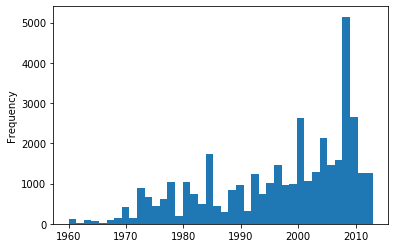

In [23]:
# Plots the known well construction years
# There are too many zeros for this information to be useful
df3 = cleaneddf.copy()
df3['construction_year'] = df3['construction_year'].where(df2['construction_year'] != 0)
avgplot(df3, 'construction_year', 40)

Many of the columns are difficult or impossible to use for one reason or another, or they are highly correlated with other columns, so I am going to drop them.

In [24]:
drop = ['amount_tsh', 'waterpoint_type_group', 'num_private', 'subvillage', 'quantity_group', 'payment_type',
       'management_group', 'extraction_type', 'extraction_type_group', 'scheme_name', 'recorded_by', 'ward',
       'district_code', 'construction_year', 'wpt_name','quality_group', 'region', 'scheme_management']

In [25]:
for x in alldfs:
    x.drop(drop, axis=1, inplace=True)

Tanzania has latitude from ~ -11 to ~ -1.1 and longitude from ~30 to ~40. Values outside that range are in error.

In [26]:
replaceless(alldfs, 'latitude', -0.00000002)
clean(cleaneddf, 'latitude', -11, -1.2)
clean(cleantest, 'latitude', -11, -1.2)

In [27]:
# replacemore(alldfs, 'longitude', 20)
# clean(cleaneddf, 'longitude', 29.7, 40.3)
# clean(cleantest, 'longitude', 29.7, 40.3)

Randomizing the lat and long made for a funny looking map, so I'm going to randomize the lat then set to the nearest long

In [28]:
longtraintrain = cleaneddf[cleaneddf.longitude > 20].loc[ : ,['id','longitude', 'latitude']]
longtraintest = cleaneddf[cleaneddf.longitude <= 20].loc[ : ,['id','longitude', 'latitude']]

longtesttrain = cleantest[cleantest.longitude > 20].loc[ : ,['id','longitude', 'latitude']]
longtesttest = cleantest[cleantest.longitude <= 20].loc[ : ,['id','longitude', 'latitude']]

In [29]:
replacemore(alldfs, 'longitude', 20)

In [30]:
longytraintrain = longtraintrain['longitude']
longxtraintrain = longtraintrain.copy()
longxtraintrain.drop(['id','longitude'], axis=1, inplace=True)
longytraintest = longtraintest.loc[ : ,['id','longitude']]
longxtraintest = longtraintest.copy()
longxtraintest.drop(['id','longitude'], axis=1, inplace=True)

In [31]:
longytesttrain = longtesttrain['longitude']
longxtesttrain = longtesttrain.copy()
longxtesttrain.drop(['id','longitude'], axis=1, inplace=True)
longytesttest = longtesttest.loc[ : ,['id','longitude']]
longxtesttest = longtesttest.copy()
longxtesttest.drop(['id','longitude'], axis=1, inplace=True)

In [32]:
clf1 = KNeighborsRegressor(n_neighbors=1, weights='distance').fit(longxtraintrain, longytraintrain)
clf2 = KNeighborsRegressor(n_neighbors=1, weights='distance').fit(longxtesttrain, longytesttrain)

longytraintest['longitude'] = clf1.predict(longxtraintest)
longytesttest['longitude'] = clf2.predict(longxtesttest)

In [33]:
cleaneddf['longitude'] = cleaneddf['longitude'].fillna(longytraintest['longitude'])
cleantest['longitude'] = cleantest['longitude'].fillna(longytesttest['longitude'])

It's unlikely that wells exist at sea level. They would have to be at the coast, as no other point in Tanzania is at or below sea level. They wouldn't need a well if they were on the beach. I think GPS is worth looking into so I'll spend more time on it.

In [34]:
# This defines dataframes with GPS Coordinates and without

gpstraintrain = cleaneddf[cleaneddf.gps_height > 3].loc[ : ,['id','longitude', 'latitude','gps_height']]
gpstraintest = cleaneddf[cleaneddf.gps_height <= 3].loc[ : ,['id','longitude', 'latitude','gps_height']]

gpstesttrain = cleantest[cleantest.gps_height > 3].loc[ : ,['id','longitude', 'latitude','gps_height']]
gpstesttest = cleantest[cleantest.gps_height <= 3].loc[ : ,['id','longitude', 'latitude','gps_height']]

In [35]:
# removing incorrect gps heights so they can be replaced
replacemore(alldfs, 'gps_height', 3)

In [36]:
ytraintrain = gpstraintrain['gps_height']
xtraintrain = gpstraintrain.copy()
xtraintrain.drop(['id','gps_height'], axis=1, inplace=True)
ytraintest = gpstraintest.loc[ : ,['id','gps_height']]
xtraintest = gpstraintest.copy()
xtraintest.drop(['id','gps_height'], axis=1, inplace=True)

In [37]:
ytesttrain = gpstesttrain['gps_height']
xtesttrain = gpstesttrain.copy()
xtesttrain.drop(['id','gps_height'], axis=1, inplace=True)
ytesttest = gpstesttest.loc[ : ,['id','gps_height']]
xtesttest = gpstesttest.copy()
xtesttest.drop(['id','gps_height'], axis=1, inplace=True)

In [38]:
clf3 = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(xtraintrain, ytraintrain)
clf4 = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(xtesttrain, ytesttrain)

In [39]:
ytraintest['gps_height'] = clf3.predict(xtraintest)
ytesttest['gps_height'] = clf4.predict(xtesttest)

In [40]:
cleaneddf['gps_height'] = cleaneddf['gps_height'].fillna(ytraintest['gps_height'])
cleantest['gps_height'] = cleantest['gps_height'].fillna(ytesttest['gps_height'])

In [41]:
# This function will make a 3d graph of the tanzanian wells
def graph3d(df):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=df.loc[df.status_group.isin(['functional']),'latitude'],
               ys=df.loc[df.status_group.isin(['functional']),'longitude'],
               zs=df.loc[df.status_group.isin(['functional']),'gps_height'],
               c='green', marker='.', alpha=0.2, s=20, label='functional')
    ax.scatter(xs=df.loc[df.status_group.isin(['non functional']),'latitude'],
               ys=df.loc[df.status_group.isin(['non functional']),'longitude'],
               zs=df.loc[df.status_group.isin(['non functional']),'gps_height'],
               c='blue', marker='x', alpha=0.75, s=34, label='non functional')
    ax.scatter(xs=df.loc[df.status_group.isin(['functional needs repair']),'latitude'],
               ys=df.loc[df.status_group.isin(['functional needs repair']),'longitude'],
               zs=df.loc[df.status_group.isin(['functional needs repair']),'gps_height'],
               c='red', marker='+', alpha=0.8, s=21, label='functional needs repair')
    ax.set_xlabel('latitude, South <--> North')
    ax.set_ylabel('longitude, East <--> West')
    ax.set_zlabel('pump height above sea level')
    ax.legend()
    ax.set_title('3D Plot of Water Pump Heights by Tanzanian Latitudes and Longitudes')

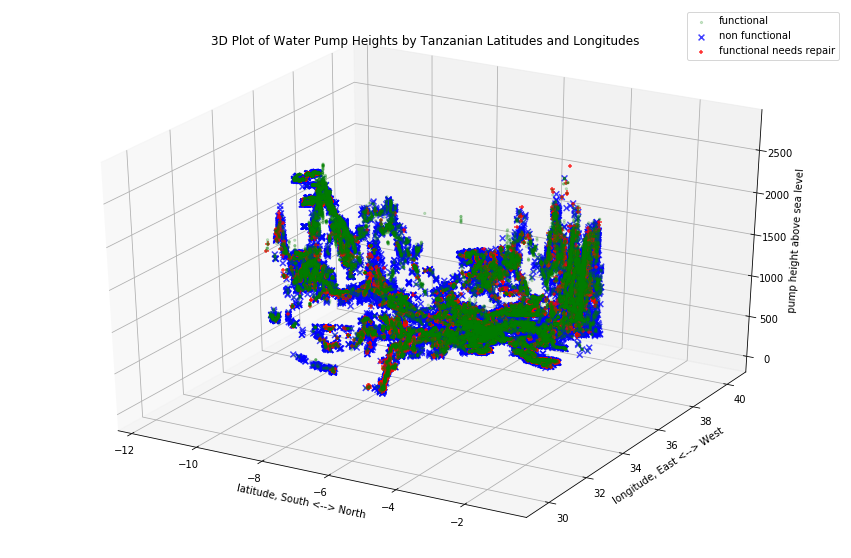

In [42]:
graph3d(cleaneddf)

C:\Users\reube\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\reube\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\reube\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


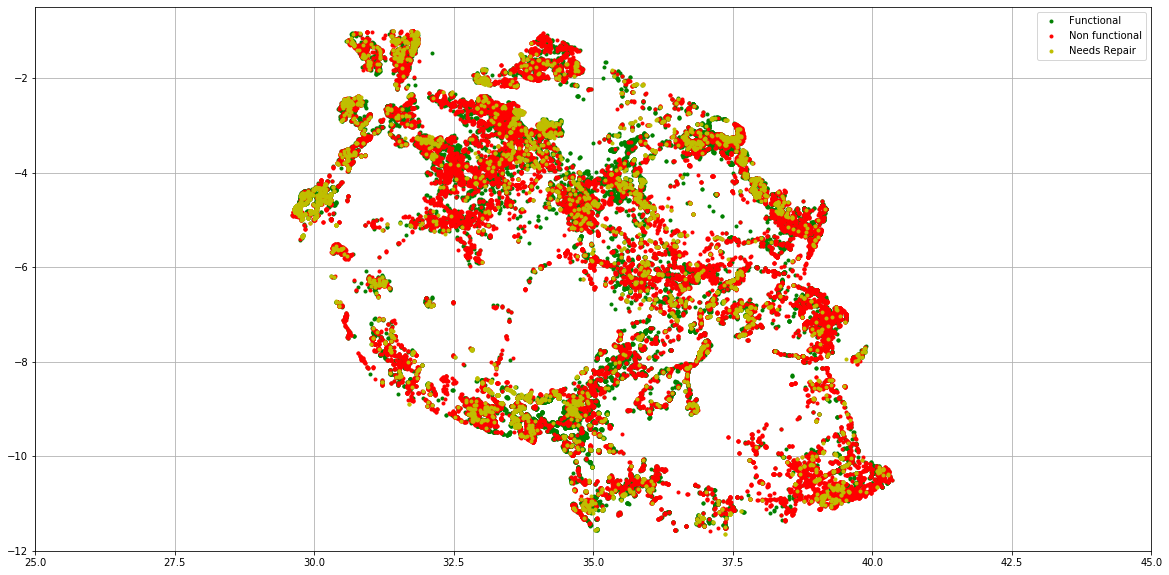

In [43]:
functional = cleaneddf[cleaneddf['status_group']=='functional']
nonfunctional = cleaneddf[cleaneddf['status_group']=='non functional']
needs = cleaneddf[cleaneddf['status_group']=='functional needs repair']

plt.figure(figsize=(20,10))
plt.plot(functional.longitude,functional.latitude,'g.')
plt.plot(nonfunctional.longitude,nonfunctional.latitude,'r.')
plt.plot(needs.longitude,needs.latitude,'y.')
plt.legend(['Functional','Non functional','Needs Repair'])
plt.axis([25,45,-12,-0.5])
plt.grid(True)

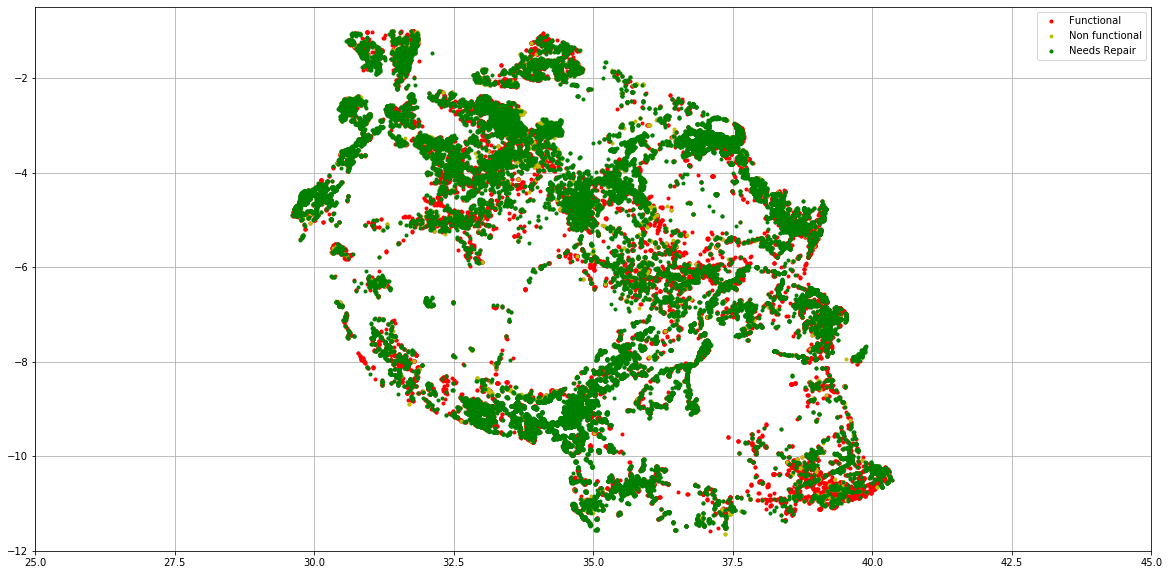

In [44]:
plt.figure(figsize=(20,10))
plt.plot(nonfunctional.longitude,nonfunctional.latitude,'r.')
plt.plot(needs.longitude,needs.latitude,'y.')
plt.plot(functional.longitude,functional.latitude,'g.')
plt.legend(['Functional','Non functional','Needs Repair'])
plt.axis([25,45,-12,-0.5])
plt.grid(True)

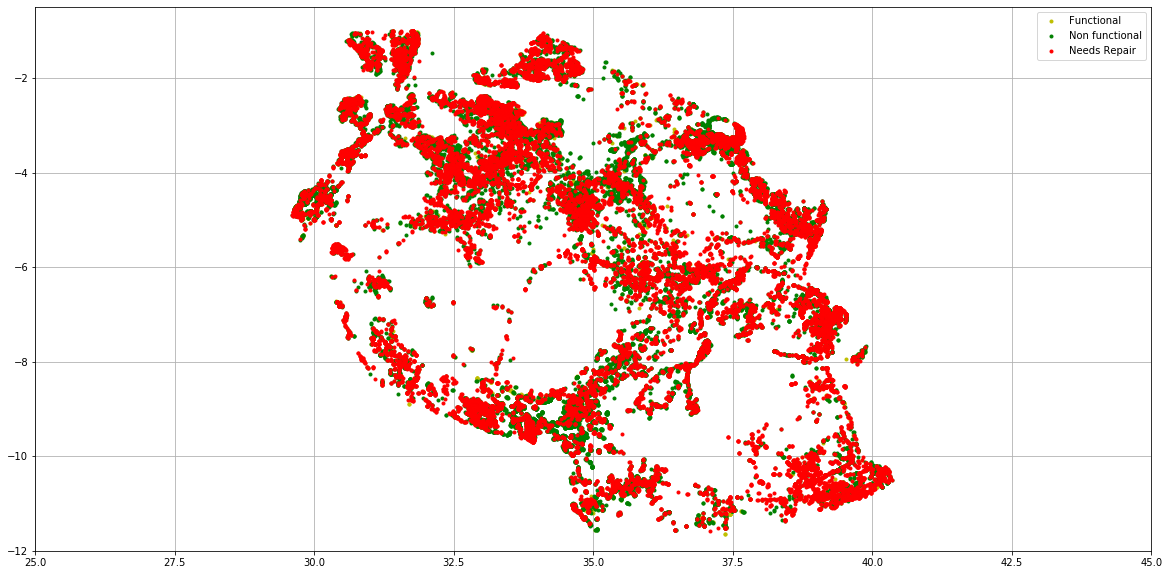

In [45]:
plt.figure(figsize=(20,10))
plt.plot(needs.longitude,needs.latitude,'y.')
plt.plot(functional.longitude,functional.latitude,'g.')
plt.plot(nonfunctional.longitude,nonfunctional.latitude,'r.')
plt.legend(['Functional','Non functional','Needs Repair'])
plt.axis([25,45,-12,-0.5])
plt.grid(True)

In [46]:
# True has by far the most so I'll fill with that
cleaneddf['public_meeting'].fillna(True,inplace=True)
cleantest['public_meeting'].fillna(True,inplace=True)
cleaneddf['permit'].fillna(True,inplace=True)
cleantest['permit'].fillna(True,inplace=True)

In [47]:
# 40 is an odd man out
df2['region_code'] = df2['region_code'].where(df2['region_code'] != 40, 11)
cleaneddf['region_code'] = cleaneddf['region_code'].where(cleaneddf['region_code'] != 40, 11)

In [48]:
encode([cleaneddf, cleantest], 'region_code')

In [49]:
# Abandoned wells are put in the same group
for x in alldfs:
    x.loc[x['water_quality'] == 'fluoride abandoned', 'water_quality'] = 'abandoned'
    x.loc[x['water_quality'] == 'salty abandoned', 'water_quality'] = 'abandoned'

In [50]:
encode([cleaneddf, cleantest], 'water_quality')

In [51]:
# Compares funder to installer, adds true if they are the same
for x in alldfs:
    x.loc[x['funder'] == 'government of tanzania', 'funder'] = 'government'
    x['selfbuilt'] = np.where(x.funder == x.installer, 'True', 'False')

In [52]:
drop = ['funder', 'installer']
cleaneddf.drop(drop, axis=1, inplace=True)
cleantest.drop(drop, axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   funder                 55765 non-null  object 
 2   gps_height             59400 non-null  float64
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  int32  
 7   region_code            59400 non-null  int64  
 8   lga                    59400 non-null  int32  
 9   population             59400 non-null  int64  
 10  public_meeting         59400 non-null  bool   
 11  scheme_management      55523 non-null  object 
 12  permit                 56344 non-null  object 
 13  extraction_type_class  59400 non-null  int32  
 14  management             59400 non-null  int32  
 15  pa

In [ ]:
cleaneddf